In [1]:
import pandas as pd
import os
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
import os
os.chdir('/data2/zhouwg_data/bioData/Bio_OS_Data/analysis')

In [3]:
def load(anndata_directory):
    anndata_list = []
    for anndata in os.listdir(anndata_directory):
        adata = sc.read_h5ad(os.path.join(anndata_directory, anndata, anndata)+'.h5ad')
        anndata_list.append(adata)

    return anndata_list

In [5]:
## define where we save the results of our analysis
results_folder = './results/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [7]:
tmp = sc.read_h5ad('../Data/WTH1039/WTH1039.h5ad')
tmp

AnnData object with n_obs × n_vars = 11479 × 32285
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'

In [8]:
adata_vis = load('../Data')

In [9]:
import anndata as ad
adata_vis = ad.concat(adata_vis, label="batch")
adata_vis.var = tmp.var
adata_vis

/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 102744 × 32285
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'

In [10]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=False, inplace=True) # 

In [11]:
adata_vis

AnnData object with n_obs × n_vars = 102744 × 32285
    obs: 'batch'
    var: 'gene_ids', 'feature_types', 'SYMBOL'
    obsm: 'spatial'

In [12]:
adata_vis.var.SYMBOL

gene_ids
ENSMUSG00000051951          Xkr4
ENSMUSG00000089699        Gm1992
ENSMUSG00000102331       Gm19938
ENSMUSG00000102343       Gm37381
ENSMUSG00000025900           Rp1
                         ...    
ENSMUSG00000095523    AC124606.1
ENSMUSG00000095475    AC133095.2
ENSMUSG00000094855    AC133095.1
ENSMUSG00000095019    AC234645.1
ENSMUSG00000095041    AC149090.1
Name: SYMBOL, Length: 32285, dtype: object

In [13]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('Mt-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

### reference adata

In [4]:
adata_ref = sc.read_h5ad('../ref_adata/snRNA_ref_brain_final.h5ad')
adata_ref

AnnData object with n_obs × n_vars = 39208 × 31053
    obs: 'Batch', 'sample', 'annotation_1', 'annotation_1_print', 'MajorCelltype', 'MinCelltype'

In [7]:
list(adata_ref.obs['MinCelltype'].unique())

['Ext_L25',
 'Ext_L56',
 'Ext_Thal_1',
 'Ext_L5_1',
 'Ext_Thal_2',
 'Ext_L23',
 'Oligo_2',
 'Inh_1',
 'Ext_Hpc_DG2',
 'OPC_1',
 'Inh_Sst',
 'Ext_L6',
 'Inh_Meis2_2',
 'Inh_3',
 'Ext_Pir',
 'Ext_L5_3',
 'Inh_4',
 'Ext_Hpc_DG1',
 'Inh_Lamp5',
 'Astro_STR',
 'Astro_CTX',
 'Nb_1',
 'Inh_Meis2_4',
 'Inh_Meis2_3',
 'Inh_Pvalb',
 'Micro',
 'OPC_2',
 'Astro_AMY',
 'Oligo_1',
 'Inh_6',
 'Ext_Amy_2',
 'Astro_THAL_lat',
 'Inh_Meis2_1',
 'Astro_AMY_CTX',
 'Ext_L6B',
 'Ext_L5_2',
 'Ext_Hpc_CA1',
 'Inh_Vip',
 'Astro_THAL_med',
 'Astro_HYPO',
 'Inh_2',
 'Ext_Hpc_CA3',
 'Ext_ClauPyr',
 'Nb_2',
 'Ext_Med',
 'Astro_HPC',
 'Ext_Hpc_CA2',
 'Astro_WM',
 'Inh_5',
 'Astro_THAL_hab',
 'Ext_Amy_1',
 'Endo',
 'Ext_Unk_3',
 'Ext_Unk_2',
 'Ext_Unk_1']

In [15]:
adata_ref.obs['MinCelltype'].value_counts()

MinCelltype
Oligo_2           10819
Ext_L56            1422
Inh_4              1389
Ext_L23            1244
Micro              1218
Ext_Thal_1         1197
OPC_1              1015
Ext_Pir             954
Ext_L25             922
Ext_Hpc_DG2         915
Ext_L5_1            893
Inh_2               839
Inh_3               818
Inh_Pvalb           804
Ext_Amy_2           797
Inh_Meis2_3         789
Ext_Hpc_CA1         671
Ext_Thal_2          671
Inh_Sst             640
Oligo_1             613
Inh_Meis2_2         602
Inh_1               573
Ext_L6              568
Ext_Hpc_DG1         554
Inh_Vip             545
Ext_Amy_1           519
Astro_AMY           498
Inh_6               467
Astro_HYPO          451
Astro_CTX           443
Ext_Unk_3           416
Astro_THAL_med      405
Inh_Meis2_1         363
Ext_L6B             356
Astro_THAL_lat      332
Inh_Lamp5           331
OPC_2               300
Astro_AMY_CTX       279
Ext_ClauPyr         272
Astro_HPC           261
Ext_Hpc_CA3         232
Nb_1

In [16]:
# import mygene
# 
# adata_ref.var['SYMBOL'] = adata_ref.var.index
# mg = mygene.MyGeneInfo()
# 
# # 示例基因名称列表
# gene_names = list(adata_ref.var.index)
# 
# # 获取ENSEMBL ID
# out = mg.querymany(gene_names, scopes='symbol', fields='ensembl.gene', species='mouse', as_dataframe=True)
# # print(out)
# 
# out['tmp'] = out.index
# out = out.drop_duplicates(subset=['tmp'])
# out

In [17]:
import pandas as pd

out = pd.DataFrame(adata_vis.var.SYMBOL)
out['gene_ids'] = out.index
out.index = out['SYMBOL']
out

SYMBOL            gene_ids
SYMBOL                                    
Xkr4              Xkr4  ENSMUSG00000051951
Gm1992          Gm1992  ENSMUSG00000089699
Gm19938        Gm19938  ENSMUSG00000102331
Gm37381        Gm37381  ENSMUSG00000102343
Rp1                Rp1  ENSMUSG00000025900
...                ...                 ...
AC124606.1  AC124606.1  ENSMUSG00000095523
AC133095.2  AC133095.2  ENSMUSG00000095475
AC133095.1  AC133095.1  ENSMUSG00000094855
AC234645.1  AC234645.1  ENSMUSG00000095019
AC149090.1  AC149090.1  ENSMUSG00000095041

[32285 rows x 2 columns]

In [20]:
adata_ref.var = adata_ref.var.join(out)

In [21]:
adata_ref.var

SYMBOL            gene_ids
Xkr4                      Xkr4  ENSMUSG00000051951
Gm1992                  Gm1992  ENSMUSG00000089699
Gm37381                Gm37381  ENSMUSG00000102343
Rp1                        Rp1  ENSMUSG00000025900
Sox17                    Sox17  ENSMUSG00000025902
...                        ...                 ...
AC168977.1          AC168977.1  ENSMUSG00000079808
AC149090.1          AC149090.1  ENSMUSG00000095041
CAAA01118383.1  CAAA01118383.1  ENSMUSG00000063897
Vmn2r122              Vmn2r122  ENSMUSG00000096730
CAAA01147332.1  CAAA01147332.1  ENSMUSG00000095742

[31053 rows x 2 columns]

In [22]:
adata_ref = adata_ref[:, adata_ref.var['gene_ids'].notna()]
adata_ref

View of AnnData object with n_obs × n_vars = 39208 × 29836
    obs: 'Batch', 'sample', 'annotation_1', 'annotation_1_print', 'MajorCelltype', 'MinCelltype'
    var: 'SYMBOL', 'gene_ids'

In [23]:
adata_ref.obs['sample'].value_counts()

sample
5705STDY8058285    9956
5705STDY8058281    7977
5705STDY8058280    7872
5705STDY8058282    5500
5705STDY8058283    5102
5705STDY8058284    2801
Name: count, dtype: int64

In [24]:
## Here we rename genes to ENSEMBL ID for correct matching between single cell and spatial data.
# rename 'gene_ids' as necessary for your data
adata_ref.var.set_index('gene_ids', drop=False, inplace=True)

In [25]:
adata_ref.var_names

Index(['ENSMUSG00000051951', 'ENSMUSG00000089699', 'ENSMUSG00000102343',
       'ENSMUSG00000025900', 'ENSMUSG00000025902', 'ENSMUSG00000104328',
       'ENSMUSG00000033845', 'ENSMUSG00000025903', 'ENSMUSG00000033813',
       'ENSMUSG00000002459',
       ...
       'ENSMUSG00000079192', 'ENSMUSG00000079794', 'ENSMUSG00000094799',
       'ENSMUSG00000095019', 'ENSMUSG00000094915', 'ENSMUSG00000079808',
       'ENSMUSG00000095041', 'ENSMUSG00000063897', 'ENSMUSG00000096730',
       'ENSMUSG00000095742'],
      dtype='object', name='gene_ids', length=29836)

/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/cell2location/utils/filtering.py:26: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = np.array((adata.X > 0).sum(0)).flatten()
/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


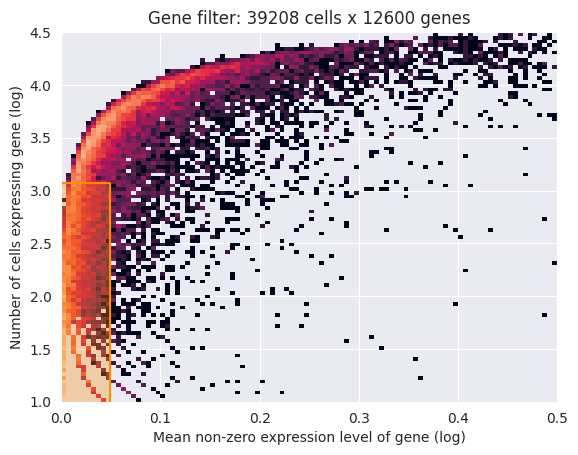

In [26]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [110]:
## Estimation of reference cell type signatures (NB regression)
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='MajorCelltype',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        # categorical_covariate_keys=['Method']
                       )

In [111]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': 'MajorCelltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   6   │
│         n_cells          │ 39208 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   8   │
│          n_vars          │ 12600 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ 5705STDY8058280 │          0          │
│                     │ 5705STDY8058281 │          1          │
│                     │ 5705STDY8058282 │          2          │
│                     │ 5705STDY8058283 │          3          │
│                     │ 5705STDY8058284 │          4          │
│                     │ 5705STDY8058285 │          5          │
└─────────────────────┴─────────────────┴─────────────────────┘

                      labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location       ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['MajorCelltype'] │   Astro    │          0          │
│                            │    Endo    │          1          │
│                            │    Ext     │          2          │
│                            │    Inh     │          3          │
│                            │   Micro    │          4          │
│                            │     Nb     │          5          │
│                            │    OPC     │          6          │
│                            │   Oligo    │          7          │
└────────────────────────────┴────────────┴─────────────────────┘

In [112]:
## Training model.
mod.train(max_epochs=250, use_gpu=True)

/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA A800 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matm

Epoch 250/250: 100%|██████████| 250/250 [21:58<00:00,  5.26s/it, v_num=1, elbo_train=2.49e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [21:58<00:00,  5.27s/it, v_num=1, elbo_train=2.49e+8]


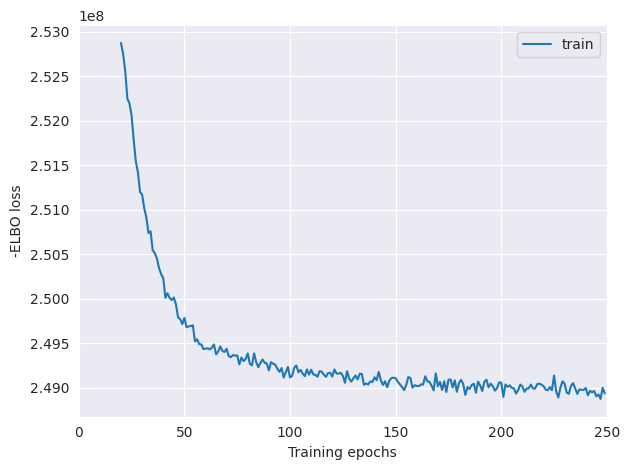

In [113]:
## Determine if the model needs more training.
mod.plot_history(20)

In [114]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:08<00:00, 115.91it/s]


'./results/WTH1039//reference_signatures/sc.h5ad'

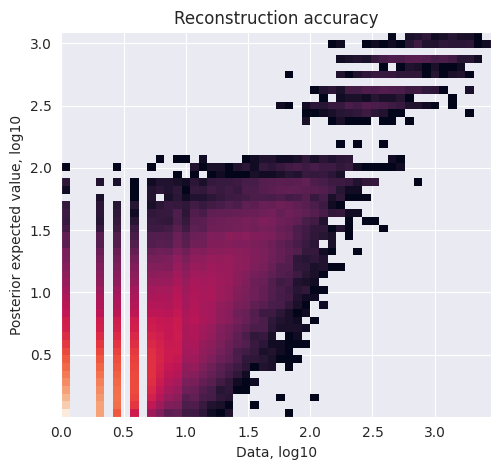

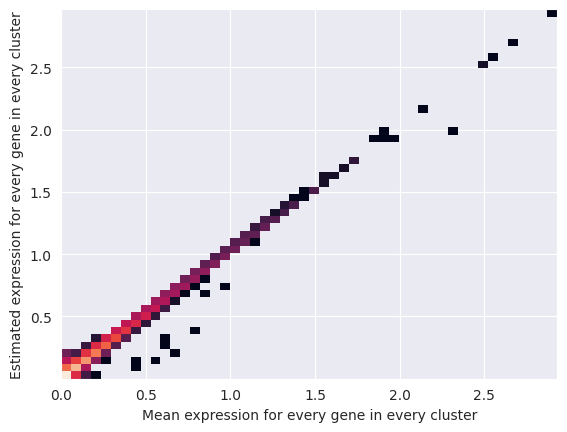

In [115]:
## Examine QC plots.
mod.plot_QC()

In [29]:
## The model and output h5ad can be loaded later like this:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File ./results//reference_signatures/model.pt already downloaded                                          


/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_utils.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_

Epoch 1/510:   0%|          | 1/510 [00:01<10:43,  1.26s/it, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/510:   0%|          | 1/510 [00:01<10:51,  1.28s/it, v_num=1]


In [30]:
## Extracting reference cell types signatures as a pd.DataFrame.
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

Astro      Endo        Ext       Inh     Micro
gene_ids                                                             
ENSMUSG00000051951  0.071578  0.038730  11.255796  8.262582  0.058581
ENSMUSG00000089699  0.005237  0.044800   1.929256  1.539913  0.002554
ENSMUSG00000025902  0.000358  0.703360   0.000128  0.000195  0.000783
ENSMUSG00000033845  0.084985  0.185955   0.226567  0.219997  0.043135
ENSMUSG00000033813  0.095833  0.134790   0.257387  0.263538  0.071313

### Cell2location: spatial mapping

In [31]:
adata_vis

View of AnnData object with n_obs × n_vars = 102744 × 32285
    obs: 'batch'
    var: 'gene_ids', 'feature_types', 'SYMBOL', 'MT_gene'
    obsm: 'spatial', 'MT'

In [33]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="batch") # 

/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [34]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=200
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'batch',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   15   │
│         n_cells          │ 102744 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │ 12600  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │     0      │          0          │
│                    │     1      │          1          │
│                    │     2      │          2          │
│                    │     3      │          3          │
│                    │     4      │          4          │
│                    │     5      │          5          │
│                    │     6      │          6          │
│                    │     7      │          7          │
│                    │     8      │          8          │
│                    │     9      │          9          │
│                    │     10     │         10          │
│                    │     11     │         11          │
│                    │     12     │         12          │
│                    │     13     │         13          │
│                    │     14     │         14          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 39/30000:   0%|          | 38/30000 [12:39<173:03:54, 20.79s/it, v_num=1, elbo_train=2.62e+8]

/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:53: Detected KeyboardInterrupt, attempting graceful shutdown...


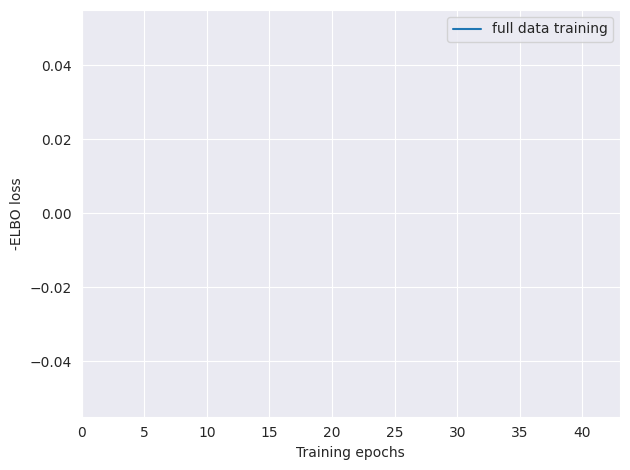

In [37]:
### Training cell2location:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=1024,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [125]:
## Exporting estimated posterior distributions of cell abundance and saving results:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:22<00:00, 44.38it/s]


'./results/WTH1039//cell2location_map/sp.h5ad'

In [38]:
## The model and output h5ad can be loaded later like this:
adata_file = f"{run_name}/sp_WTH1039.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

INFO     File ./results//cell2location_map/model.pt already downloaded                                             


/home/zhouweige/anaconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_utils.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_

Epoch 1/30000:   0%|          | 1/30000 [00:00<1:18:00,  6.41it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:00<1:21:25,  6.14it/s, v_num=1]


In [58]:
adata_ref

AnnData object with n_obs × n_vars = 39208 × 12600
    obs: 'Batch', 'sample', 'annotation_1', 'annotation_1_print', 'MajorCelltype', 'MinCelltype', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'SYMBOL', 'gene_ids', 'n_cells', 'nonz_mean'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod'
    varm: 'means_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg', 'stds_per_cluster_mu_fg'

In [71]:
adata_ref.obs['MajorCelltype'].unique()

['Ext', 'Oligo', 'Inh', 'OPC', 'Astro', 'Nb', 'Micro', 'Endo']
Categories (8, object): ['Astro', 'Endo', 'Ext', 'Inh', 'Micro', 'Nb', 'OPC', 'Oligo']

In [54]:
adata_vis.obsm['q05_cell_abundance_w_sf'].columns

Index(['q05cell_abundance_w_sf_Astro', 'q05cell_abundance_w_sf_Endo',
       'q05cell_abundance_w_sf_Ext', 'q05cell_abundance_w_sf_Inh',
       'q05cell_abundance_w_sf_Micro', 'q05cell_abundance_w_sf_Nb',
       'q05cell_abundance_w_sf_OPC', 'q05cell_abundance_w_sf_Oligo'],
      dtype='object')

In [60]:
adata_vis.obsm['q05_cell_abundance_w_sf']

q05cell_abundance_w_sf_Astro  \
TTTACCACGAGATTCGTCTAAGTACGA                      0.029289   
GTCGAATTACTAAACTGTAGTCATACG                      0.009085   
AATGGAATACCCAGTGGAGCGACGGAT                      0.011772   
GGCACGTTACTATGCAACCTAATAACG                      5.246176   
TGTTTGTTACTAGATCAGCTCTGCTTC                      0.003517   
...                                                   ...   
CATGCGGTACATGGTACAAGGCACTAT                     14.609400   
GGGTCTGCGATCGGTATTTCTGCGCTC                      3.283384   
GAAATGATACCCTAACTGCTCTGCTTC                    130.683743   
CATTGCCATGGTTCTATAAGGCACTAT                    171.512289   
GGGCGTTGCTGGTGTGACCTAATAACG                    329.294887   

                             q05cell_abundance_w_sf_Endo  \
TTTACCACGAGATTCGTCTAAGTACGA                     0.148039   
GTCGAATTACTAAACTGTAGTCATACG                     0.089408   
AATGGAATACCCAGTGGAGCGACGGAT                     0.088101   
GGCACGTTACTATGCAACCTAATAACG                     0.001185   
TGTTTGTTACTAGATCAGCTCTGCTTC                     0.001245   
...                                                  ...   
CATGCGGTACATGGTACAAGGCACTAT                    10.825382   
GGGTCTGCGATCGGTATTTCTGCGCTC                    11.247847   
GAAATGATACCCTAACTGCTCTGCTTC                   131.007904   
CATTGCCATGGTTCTATAAGGCACTAT                   145.885922   
GGGCGTTGCTGGTGTGACCTAATAACG                   265.766592   

                             q05cell_abundance_w_sf_Ext  \
TTTACCACGAGATTCGTCTAAGTACGA                    0.000185   
GTCGAATTACTAAACTGTAGTCATACG                    0.000568   
AATGGAATACCCAGTGGAGCGACGGAT                    0.000062   
GGCACGTTACTATGCAACCTAATAACG                    0.000446   
TGTTTGTTACTAGATCAGCTCTGCTTC                    0.000555   
...                                                 ...   
CATGCGGTACATGGTACAAGGCACTAT                  133.061952   
GGGTCTGCGATCGGTATTTCTGCGCTC                   66.383389   
GAAATGATACCCTAACTGCTCTGCTTC                    0.340615   
CATTGCCATGGTTCTATAAGGCACTAT                    0.502295   
GGGCGTTGCTGGTGTGACCTAATAACG                    1.083048   

                             q05cell_abundance_w_sf_Inh  \
TTTACCACGAGATTCGTCTAAGTACGA                    0.000194   
GTCGAATTACTAAACTGTAGTCATACG                    0.001384   
AATGGAATACCCAGTGGAGCGACGGAT                    0.000076   
GGCACGTTACTATGCAACCTAATAACG                    0.003163   
TGTTTGTTACTAGATCAGCTCTGCTTC                    0.002811   
...                                                 ...   
CATGCGGTACATGGTACAAGGCACTAT                    0.791247   
GGGTCTGCGATCGGTATTTCTGCGCTC                   53.659805   
GAAATGATACCCTAACTGCTCTGCTTC                   16.286791   
CATTGCCATGGTTCTATAAGGCACTAT                   23.432133   
GGGCGTTGCTGGTGTGACCTAATAACG                   21.443160   

                             q05cell_abundance_w_sf_Micro  \
TTTACCACGAGATTCGTCTAAGTACGA                      5.547721   
GTCGAATTACTAAACTGTAGTCATACG                      0.178362   
AATGGAATACCCAGTGGAGCGACGGAT                      6.113472   
GGCACGTTACTATGCAACCTAATAACG                      0.003042   
TGTTTGTTACTAGATCAGCTCTGCTTC                      0.005428   
...                                                   ...   
CATGCGGTACATGGTACAAGGCACTAT                      5.725752   
GGGTCTGCGATCGGTATTTCTGCGCTC                      6.531907   
GAAATGATACCCTAACTGCTCTGCTTC                     88.677184   
CATTGCCATGGTTCTATAAGGCACTAT                    103.041419   
GGGCGTTGCTGGTGTGACCTAATAACG                    177.965772   

                             q05cell_abundance_w_sf_Nb  \
TTTACCACGAGATTCGTCTAAGTACGA                   0.001711   
GTCGAATTACTAAACTGTAGTCATACG                   3.368226   
AATGGAATACCCAGTGGAGCGACGGAT                   0.000665   
GGCACGTTACTATGCAACCTAATAACG                   0.004323   
TGTTTGTTACTAGATCAGCTCTGCTTC                   0.000629   
...                                                ...   
CATGCGGTACATGGTACA

In [67]:
df = adata_vis.obsm['q05_cell_abundance_w_sf'].copy()
# 提取barcode列并去除前缀找到最大置信度的celltype
df['predict_MajorCelltype'] = df.idxmax(axis=1) # .drop('barcode', axis=1).

# 切割字符串，提取最后一个单词作为celltype
df['predict_MajorCelltype'] = df['predict_MajorCelltype'].str.split('_').str[-1]

# 删除其他列，只保留barcode和final_celltype
final_df = df[['predict_MajorCelltype']]
final_df

predict_MajorCelltype
TTTACCACGAGATTCGTCTAAGTACGA                 Micro
GTCGAATTACTAAACTGTAGTCATACG                    Nb
AATGGAATACCCAGTGGAGCGACGGAT                 Micro
GGCACGTTACTATGCAACCTAATAACG                 Astro
TGTTTGTTACTAGATCAGCTCTGCTTC                   OPC
...                                           ...
CATGCGGTACATGGTACAAGGCACTAT                   Ext
GGGTCTGCGATCGGTATTTCTGCGCTC                   Ext
GAAATGATACCCTAACTGCTCTGCTTC                  Endo
CATTGCCATGGTTCTATAAGGCACTAT                 Astro
GGGCGTTGCTGGTGTGACCTAATAACG                 Astro

[11479 rows x 1 columns]

In [69]:
adata_vis.obs = adata_vis.obs.join(final_df)
adata_vis

AnnData object with n_obs × n_vars = 11479 × 12600
    obs: '_indices', '_scvi_batch', '_scvi_labels', 'Astro', 'Endo', 'Ext', 'Inh', 'Micro', 'Nb', 'OPC', 'Oligo', 'predict_MajorCelltype'
    var: 'gene_ids', 'feature_types', 'SYMBOL'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [39]:
mod.plot_QC()

RuntimeError: self.samples is missing, please run self.export_posterior() first

In [ ]:
# fig = mod.plot_spatial_QC_across_batches()

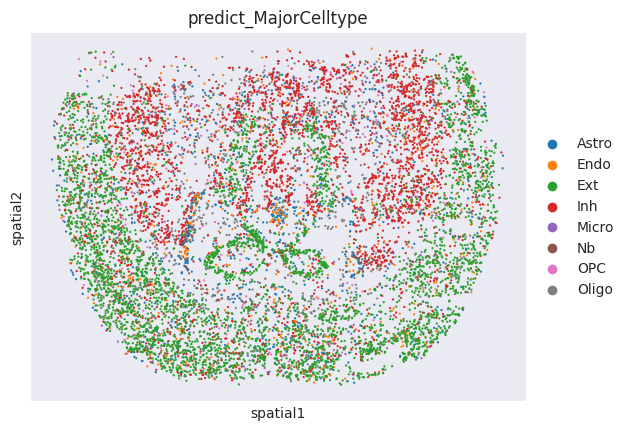

In [75]:
sc.pl.embedding(adata_vis, basis="spatial", color="predict_MajorCelltype", 
                save='_cell2location_{}.pdf'.format('WTH1039'))

In [72]:
# 创建独热编码
cell_types = ['Ext', 'Oligo', 'Inh', 'OPC', 'Astro', 'Nb', 'Micro', 'Endo']
for cell_type in cell_types:
    final_df[cell_type] = (final_df['predict_MajorCelltype'] == cell_type).astype(int)
final_df

predict_MajorCelltype  Ext  Oligo  Inh  OPC  \
TTTACCACGAGATTCGTCTAAGTACGA                 Micro    0      0    0    0   
GTCGAATTACTAAACTGTAGTCATACG                    Nb    0      0    0    0   
AATGGAATACCCAGTGGAGCGACGGAT                 Micro    0      0    0    0   
GGCACGTTACTATGCAACCTAATAACG                 Astro    0      0    0    0   
TGTTTGTTACTAGATCAGCTCTGCTTC                   OPC    0      0    0    1   
...                                           ...  ...    ...  ...  ...   
CATGCGGTACATGGTACAAGGCACTAT                   Ext    1      0    0    0   
GGGTCTGCGATCGGTATTTCTGCGCTC                   Ext    1      0    0    0   
GAAATGATACCCTAACTGCTCTGCTTC                  Endo    0      0    0    0   
CATTGCCATGGTTCTATAAGGCACTAT                 Astro    0      0    0    0   
GGGCGTTGCTGGTGTGACCTAATAACG                 Astro    0      0    0    0   

                             Astro  Nb  Micro  Endo  
TTTACCACGAGATTCGTCTAAGTACGA      0   0      1     0  
GTCGAATTACTAAACTGTAGTCATACG      0   1      0     0  
AATGGAATACCCAGTGGAGCGACGGAT      0   0      1     0  
GGCACGTTACTATGCAACCTAATAACG      1   0      0     0  
TGTTTGTTACTAGATCAGCTCTGCTTC      0   0      0     0  
...                            ...  ..    ...   ...  
CATGCGGTACATGGTACAAGGCACTAT      0   0      0     0  
GGGTCTGCGATCGGTATTTCTGCGCTC      0   0      0     0  
GAAATGATACCCTAACTGCTCTGCTTC      0   0      0     1  
CATTGCCATGGTTCTATAAGGCACTAT      1   0      0     0  
GGGCGTTGCTGGTGTGACCTAATAACG      1   0      0     0  

[11479 rows x 9 columns]

In [ ]:
## 保存结果
final_df.to_csv(outputpath, sep=',',index=True, header=True)

In [10]:
import pandas as pd
import os
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

import os
os.chdir('/data2/zhouwg_data/bioData/Bio_OS_Data/analysis')

def load(anndata_directory):
    anndata_list = []
    for anndata in os.listdir(anndata_directory):
        adata = sc.read_h5ad(os.path.join(anndata_directory, anndata, anndata)+'.h5ad')
        adata.obs['batch'] = anndata
        anndata_list.append(adata)

    return anndata_list

## define where we save the results of our analysis
results_folder = './results/'

# load data
adata_list = load('../Data')
adata_list

[AnnData object with n_obs × n_vars = 9197 × 32285
     obs: 'batch'
     var: 'gene_ids', 'feature_types'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 7635 × 32285
     obs: 'batch'
     var: 'gene_ids', 'feature_types'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 6146 × 32285
     obs: 'batch'
     var: 'gene_ids', 'feature_types'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 14386 × 32285
     obs: 'batch'
     var: 'gene_ids', 'feature_types'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 1399 × 32285
     obs: 'batch'
     var: 'gene_ids', 'feature_types'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 1638 × 32285
     obs: 'batch'
     var: 'gene_ids', 'feature_types'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 2812 × 32285
     obs: 'batch'
     var: 'gene_ids', 'feature_types'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 2837 × 32285
     obs: 'batch'
     var: 'gene_ids', 'feat

In [6]:
adata_list[0].var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [12]:
import scanpy as sc
import numpy as np

for adata in adata_list:
    sample_name = adata.obs['batch'].unique()[0]
    print('Runing {} ...'.format(sample_name))
    # 计算每个细胞的表达基因数
    adata.obs['n_genes_by_counts'] = (adata.X > 0).sum(axis=1)
    
    # 计算每个细胞的总计数
    adata.obs['total_counts'] = adata.X.sum(axis=1)
    
    # 计算n_genes_by_counts和total_counts的中位数和均值
    n_genes_median = np.median(adata.obs['n_genes_by_counts'])
    n_genes_mean = np.mean(adata.obs['n_genes_by_counts'])
    
    total_counts_median = np.median(adata.obs['total_counts'])
    total_counts_mean = np.mean(adata.obs['total_counts'])
    
    # 将结果添加到AnnData对象中
    adata.obs['n_genes_by_counts_median'] = n_genes_median
    adata.obs['n_genes_by_counts_mean'] = n_genes_mean
    
    adata.obs['total_counts_median'] = total_counts_median
    adata.obs['total_counts_mean'] = total_counts_mean
    
    # sc.pl.violin(adata, ["n_genes_by_counts", "total_counts"], 
    #              jitter=0.4, multi_panel=True, save='_{}.pdf'.format(sample_name))
    
    # 打印前几行结果进行验证
    print('n_genes_by_counts_median is', adata.obs['n_genes_by_counts_median'].unique())
    print('total_counts_median is', adata.obs['total_counts_median'].unique())
    print('n_genes_by_counts_mean is', adata.obs['n_genes_by_counts_mean'].unique())
    print('total_counts_mean is', adata.obs['total_counts_mean'].unique())

Runing WTH1058 ...
n_genes_by_counts_median is [539.]
total_counts_median is [845.]
n_genes_by_counts_mean is [599.95715994]
total_counts_mean is [1013.9982]
Runing WTH985 ...
n_genes_by_counts_median is [917.]
total_counts_median is [2465.]
n_genes_by_counts_mean is [1180.63955468]
total_counts_mean is [3920.9895]
Runing WTH1079 ...
n_genes_by_counts_median is [736.5]
total_counts_median is [1306.]
n_genes_by_counts_mean is [967.83794338]
total_counts_mean is [2200.3184]
Runing WTH1092 ...
n_genes_by_counts_median is [634.]
total_counts_median is [1092.5]
n_genes_by_counts_mean is [727.34074795]
total_counts_mean is [1401.9818]
Runing WTH706 ...
n_genes_by_counts_median is [328.]
total_counts_median is [438.]
n_genes_by_counts_mean is [364.47891351]
total_counts_mean is [506.57184]
Runing WTH725 ...
n_genes_by_counts_median is [286.]
total_counts_median is [354.]
n_genes_by_counts_mean is [312.17277167]
total_counts_mean is [397.6221]
Runing WTH665 ...
n_genes_by_counts_median is [362

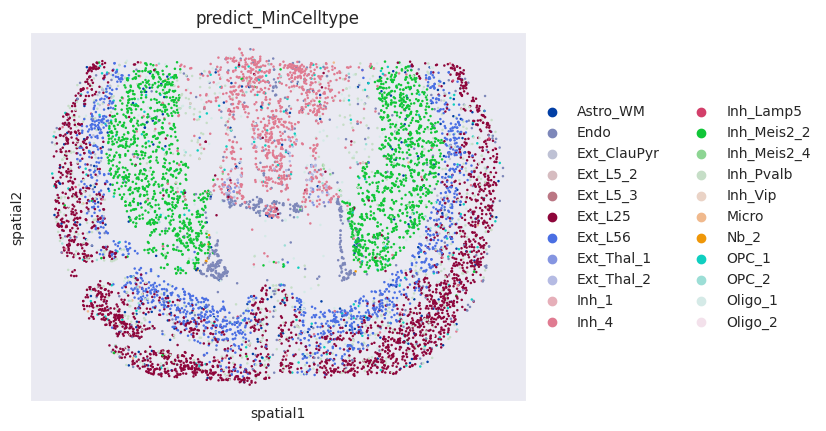

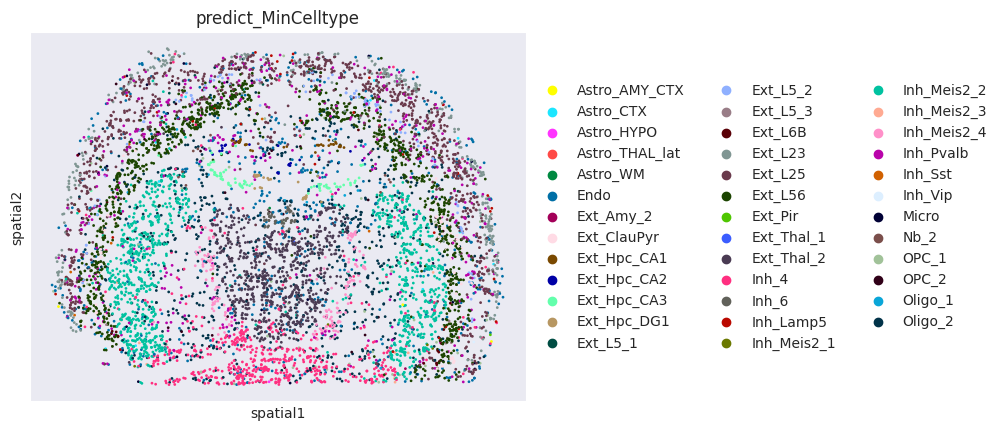

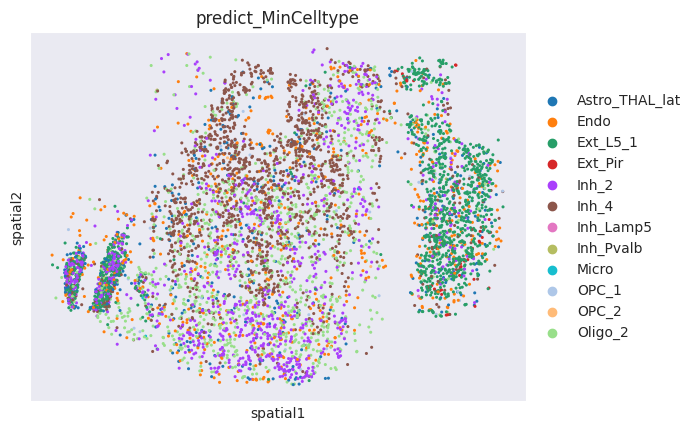

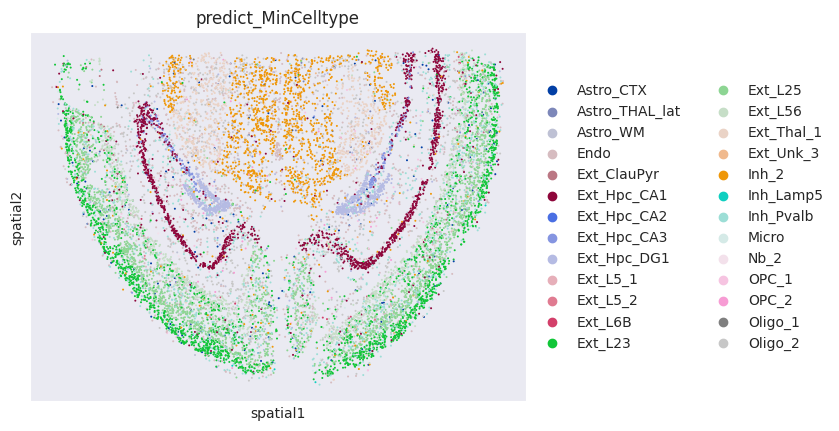

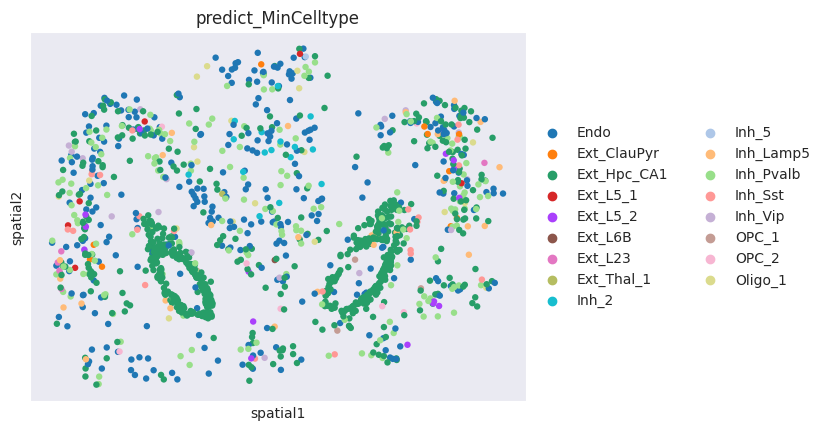

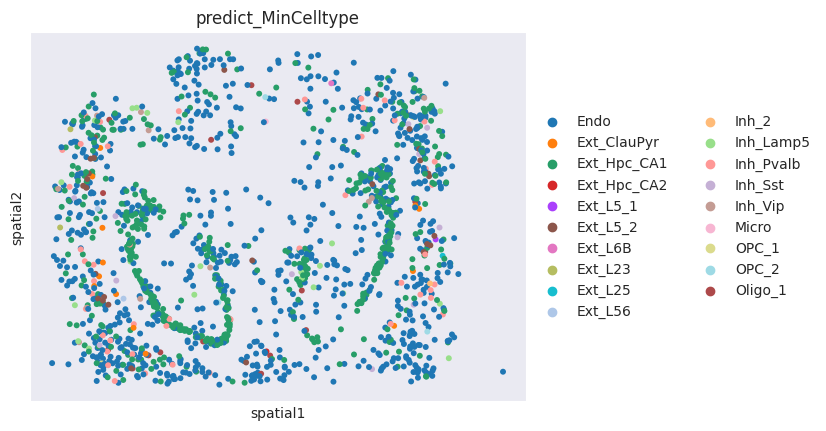

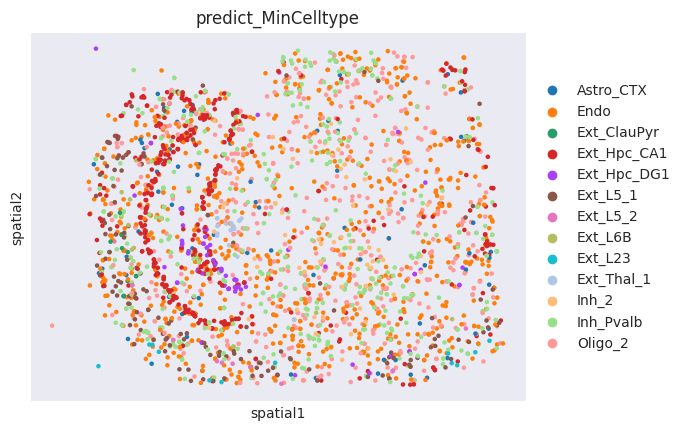

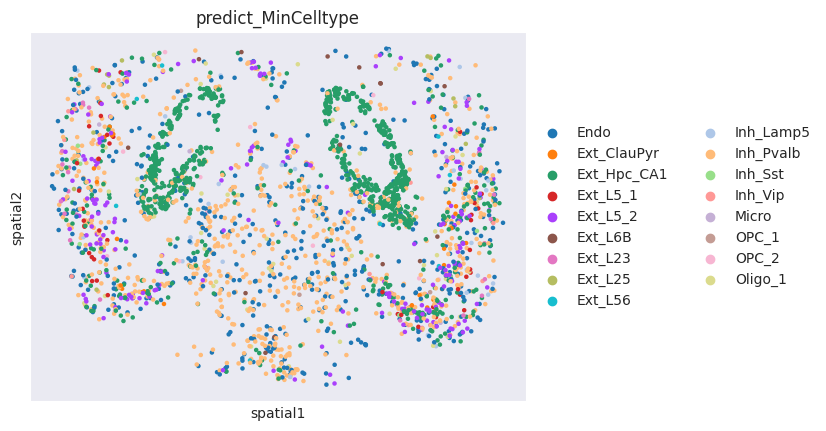

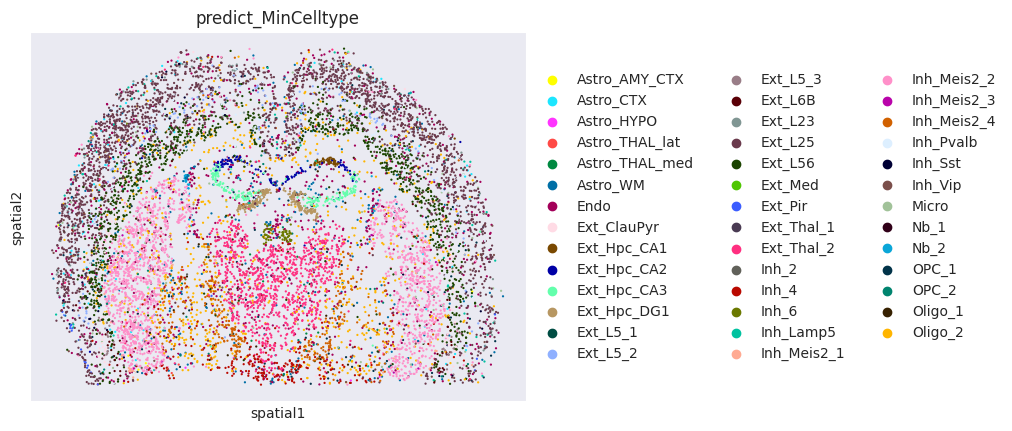

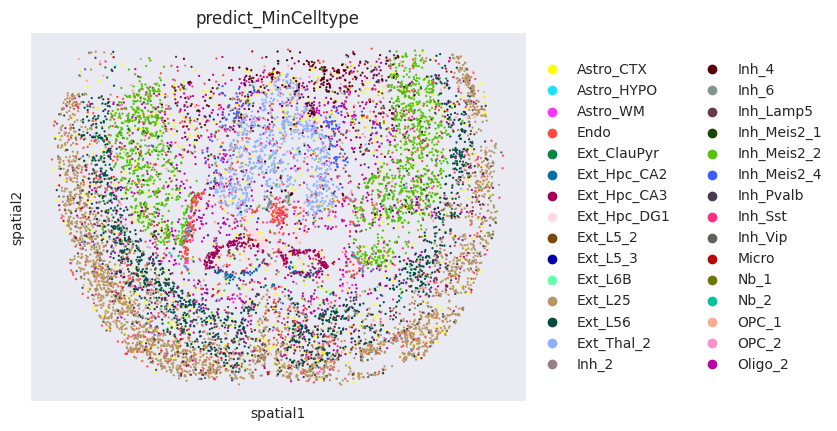

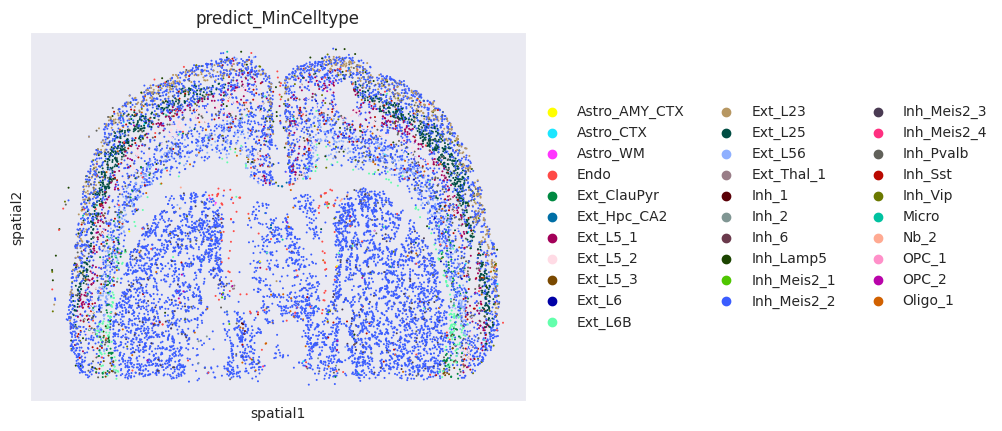

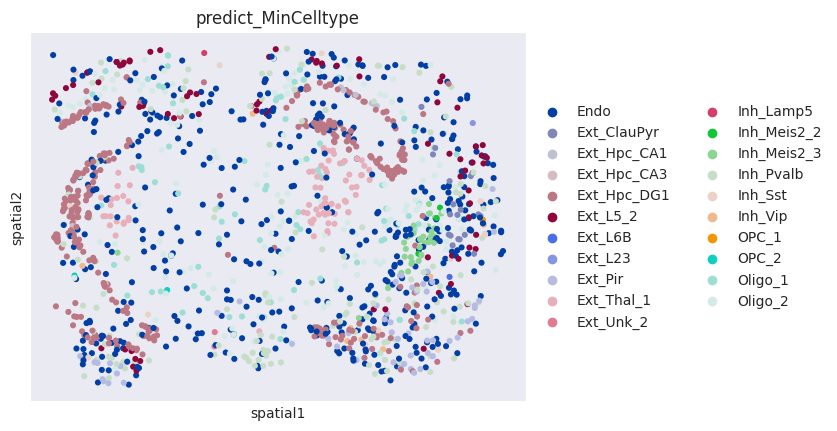

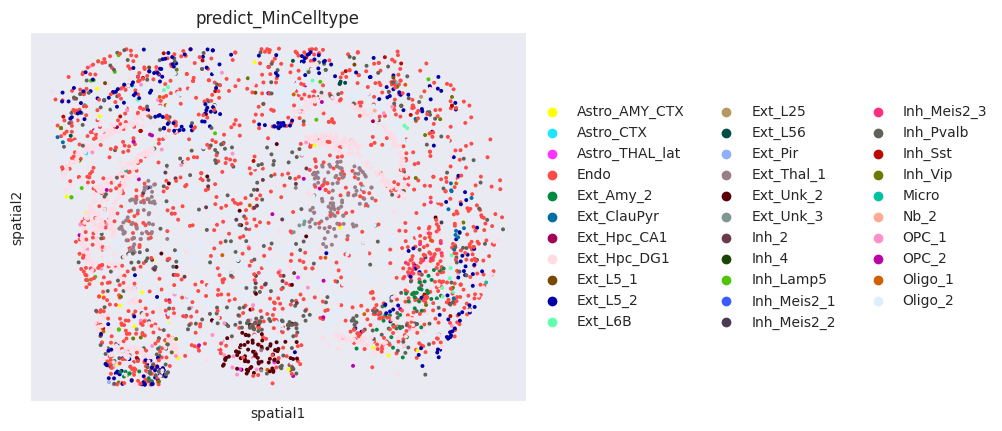

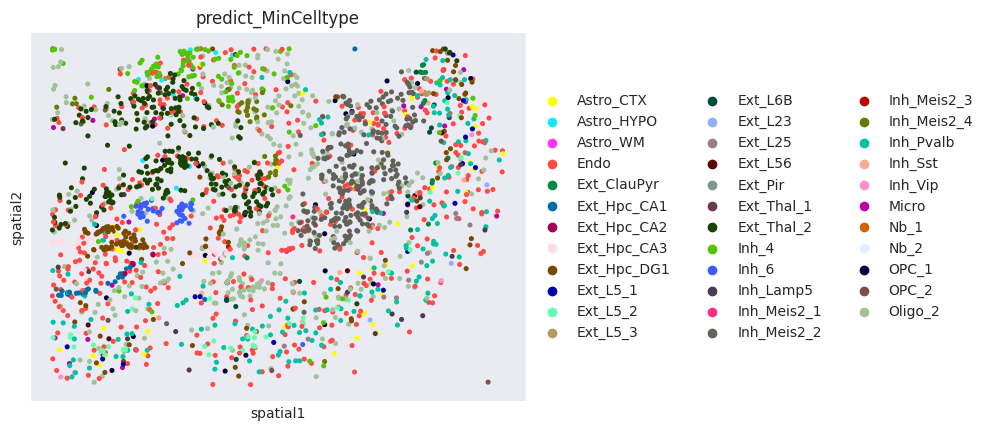

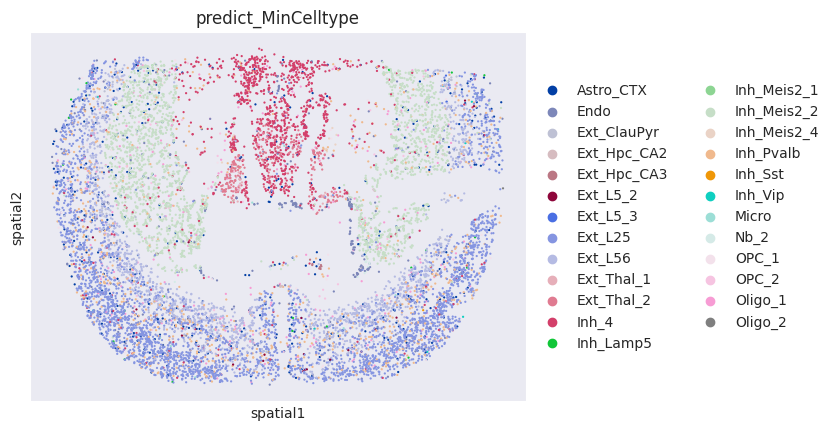

In [69]:
for adata_vis in adata_list:
    sample_name = adata_vis.obs['batch'].unique()[0]
    meta = pd.read_csv('./results/MinCellType/groundtruth/gold_{}.csv'.format(sample_name), index_col=0)
    meta = meta.iloc[:, 0]
    meta = pd.DataFrame(meta)
    meta.loc[:, 'predict_MinCelltype'] = meta.loc[:, 'predict_MinCelltype'].str.replace('q05cell_abundance_w_sf_', '', regex=False)
    adata_vis.obs = adata_vis.obs.join(meta)
    
    sc.pl.embedding(adata_vis, basis="spatial", color="predict_MinCelltype",
                    save='_cell2location2_{}.pdf'.format(sample_name))

In [83]:
## cell2location 数据预处理
for adata_vis in adata_list:
    sample_name = adata_vis.obs['batch'].unique()[0]
    meta = pd.read_csv('./results/MinCellType/groundtruth/gold_{}.csv'.format(sample_name), index_col=0)
    meta.loc[:, 'predict_MinCelltype'] = meta.loc[:, 'predict_MinCelltype'].str.replace('q05cell_abundance_w_sf_', '', regex=False)
    # 创建独热编码
    cell_types = list(meta.columns.drop('predict_MinCelltype'))
    for cell_type in cell_types:
        meta[cell_type] = (meta['predict_MinCelltype'] == cell_type).astype(int)
    
    ## 保存结果
    meta.to_csv(f"{results_folder}/MinCellType/groundtruth/gold_{sample_name}.csv", sep=',', index=True, header=True)

In [91]:
## Garfield 数据预处理
results_folder = './results/MinCellType'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)

for adata_vis in adata_list:
    sample_name = adata_vis.obs['batch'].unique()[0]
    meta = pd.read_csv('./results/predict_label/pred_Min_{}.csv'.format(sample_name), index_col=0)
    meta = meta.drop(columns=['Unnamed: 2'])
    meta.rename(columns={'transferred_MinCelltype_unfiltered':'predict_MinCelltype'}, inplace = True)
    
    # 创建独热编码
    cell_types = list(adata_ref.obs['MinCelltype'].unique())
    for cell_type in cell_types:
        meta[cell_type] = (meta['predict_MinCelltype'] == cell_type).astype(int)
    
    ## 保存结果
    meta.to_csv(f"./results/predict_label/pred_Min_{sample_name}.csv", sep=',', index=True, header=True)

In [93]:
results_folder = './results/MajorCellType'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)

for adata_vis in adata_list:
    sample_name = adata_vis.obs['batch'].unique()[0]
    meta = pd.read_csv('./results/predict_label/pred_Major_{}.csv'.format(sample_name), index_col=0)
    meta = meta.drop(columns=['Unnamed: 2'])
    meta.rename(columns={'transferred_MajorCelltype_unfiltered':'predict_MajorCelltype'}, inplace = True)
    
    # 创建独热编码
    cell_types = list(adata_ref.obs['MajorCelltype'].unique())
    for cell_type in cell_types:
        meta[cell_type] = (meta['predict_MajorCelltype'] == cell_type).astype(int)
    
    ## 保存结果
    meta.to_csv(f"./results/predict_label/pred_Major_{sample_name}.csv", sep=',', index=True, header=True)

In [97]:
meta = pd.read_csv('./results/predict_label/pred_Min_{}.csv'.format(sample_name), index_col=0)
meta

predict_MinCelltype  Ext_L25  Ext_L56  Ext_Thal_1  \
AGGCCACTACCGTATAACATGGCGTAC                Nb_2        0        0           0   
AACGAAAATGCACGTAACATGGCGTAC         Ext_Hpc_DG2        0        0           0   
ACACAGTGCTTGCAAGGAGACCGCCTT                Nb_1        0        0           0   
AGAGCAGCGAGTCAGAGCATGGCGTAC               OPC_1        0        0           0   
GCATCTCATGTAAAGCTAAGTTACTCG             Oligo_2        0        0           0   
...                                         ...      ...      ...         ...   
CTAACCCATGGCTGAACTTCAGGTGGC            Ext_L5_1        0        0           0   
CCCTTAGGCTTTGATCGGCACATACAA                Endo        0        0           0   
CGATGCGCGAACAAGTATTCAGGTGGC                Endo        0        0           0   
TAGAGTCTACATGCAGCAGACCGCCTT                Endo        0        0           0   
AGTGATCGCTCTGTGATTTCAGGTGGC             Ext_L23        0        0           0   

                             Ext_L5_1  Ext_Thal_2  Ext_L23  Oligo_2  Inh_1  \
AGGCCACTACCGTATAACATGGCGTAC         0           0        0        0      0   
AACGAAAATGCACGTAACATGGCGTAC         0           0        0        0      0   
ACACAGTGCTTGCAAGGAGACCGCCTT         0           0        0        0      0   
AGAGCAGCGAGTCAGAGCATGGCGTAC         0           0        0        0      0   
GCATCTCATGTAAAGCTAAGTTACTCG         0           0        0        1      0   
...                               ...         ...      ...      ...    ...   
CTAACCCATGGCTGAACTTCAGGTGGC         1           0        0        0      0   
CCCTTAGGCTTTGATCGGCACATACAA         0           0        0        0      0   
CGATGCGCGAACAAGTATTCAGGTGGC         0           0        0        0      0   
TAGAGTCTACATGCAGCAGACCGCCTT         0           0        0        0      0   
AGTGATCGCTCTGTGATTTCAGGTGGC         0           0        1        0      0   

                             Ext_Hpc_DG2  ...  Astro_HPC  Ext_Hpc_CA2  \
AGGCCACTACCGTATAACATGGCGTAC            0  ...          0            0   
AACGAAAATGCACGTAACATGGCGTAC            1  ...          0            0   
ACACAGTGCTTGCAAGGAGACCGCCTT            0  ...          0            0   
AGAGCAGCGAGTCAGAGCATGGCGTAC            0  ...          0            0   
GCATCTCATGTAAAGCTAAGTTACTCG            0  ...          0            0   
...                                  ...  ...        ...          ...   
CTAACCCATGGCTGAACTTCAGGTGGC            0  ...          0            0   
CCCTTAGGCTTTGATCGGCACATACAA            0  ...          0            0   
CGATGCGCGAACAAGTATTCAGGTGGC            0  ...          0            0   
TAGAGTCTACATGCAGCAGACCGCCTT            0  ...          0            0   
AGTGATCGCTCTGTGATTTCAGGTGGC            0  ...          0            0   

                             Astro_WM  Inh_5  Astro_THAL_hab  Ext_Amy_1  Endo  \
AGGCCACTACCGTATAACATGGCGTAC         0      0               0          0     0   
AACGAAAATGCACGTAACATGGCGTAC         0      0               0          0     0   
ACACAGTGCTTGCAAGGAGACCGCCTT         0      0               0          0     0   
AGAGCAGCGAGTCAGAGCATGGCGTAC         0      0               0          0     0   
GCATCTCATGTAAAGCTAAGTTACTCG         0      0               0          0     0   
...                               ...    ...             ...        ...   ...   
CTAACCCATGGCTGAACTTCAGGTGGC         0      0               0          0     0   
CCCTTAGGCTTTGATCGGCACATACAA         0      0               0          0     1   
CGATGCGCGAACAAGTATTCAGGTGGC         0      0               0          0     1   
TAGAGTCTACATGCAGCAGACCGCCTT         0      0               0          0     1   
AGTGATCGCTCTGTGATTTCAGGTGGC         0      0               0          0     0   

                             Ext_Unk_3  Ext_Unk_2  Ext_Unk_1  
AGGCCACTACCGTATAACATGGCGTAC          0          0          0  
AACGAAAATGCACGTAACATGGCGTAC          0          0          0  
ACACAGTGCTTGCAAGGAGACCGCCTT          0          0          0  
AGAGCAGCGAGTCAGA

In [98]:
pd.read_csv('./results/MajorCellType/groundtruth/gold_{}.csv'.format(sample_name))

predict_MajorCelltype  Ext  Oligo  Inh  OPC  \
AGGCCACTACCGTATAACATGGCGTAC                   Inh    0      0    1    0   
AACGAAAATGCACGTAACATGGCGTAC                   Inh    0      0    1    0   
ACACAGTGCTTGCAAGGAGACCGCCTT                   Inh    0      0    1    0   
AGAGCAGCGAGTCAGAGCATGGCGTAC                   OPC    0      0    0    1   
GCATCTCATGTAAAGCTAAGTTACTCG                 Oligo    0      1    0    0   
...                                           ...  ...    ...  ...  ...   
CTAACCCATGGCTGAACTTCAGGTGGC                   Ext    1      0    0    0   
CCCTTAGGCTTTGATCGGCACATACAA                  Endo    0      0    0    0   
CGATGCGCGAACAAGTATTCAGGTGGC                  Endo    0      0    0    0   
TAGAGTCTACATGCAGCAGACCGCCTT                  Endo    0      0    0    0   
AGTGATCGCTCTGTGATTTCAGGTGGC                   Inh    0      0    1    0   

                             Astro  Nb  Micro  Endo  
AGGCCACTACCGTATAACATGGCGTAC      0   0      0     0  
AACGAAAATGCACGTAACATGGCGTAC      0   0      0     0  
ACACAGTGCTTGCAAGGAGACCGCCTT      0   0      0     0  
AGAGCAGCGAGTCAGAGCATGGCGTAC      0   0      0     0  
GCATCTCATGTAAAGCTAAGTTACTCG      0   0      0     0  
...                            ...  ..    ...   ...  
CTAACCCATGGCTGAACTTCAGGTGGC      0   0      0     0  
CCCTTAGGCTTTGATCGGCACATACAA      0   0      0     1  
CGATGCGCGAACAAGTATTCAGGTGGC      0   0      0     1  
TAGAGTCTACATGCAGCAGACCGCCTT      0   0      0     1  
AGTGATCGCTCTGTGATTTCAGGTGGC      0   0      0     0  

[11634 rows x 9 columns]

In [115]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def calculate_auc_from_csv(adata_list):
    results = {}
    
    for adata_vis in adata_list:
        sample_name = adata_vis.obs['batch'].unique()[0]
        print('Calculating AUC for {}'.format(sample_name))
        
        # 创建 ground truth 和 predict 数据框
        df_ground_truth = pd.read_csv('./results/MajorCellType/groundtruth/gold_{}.csv'.format(sample_name), index_col=0)
        df_predict = pd.read_csv('./results/predict_label/pred_Major_{}.csv'.format(sample_name), index_col=0)
        df_ground_truth = df_ground_truth[['predict_MajorCelltype']]
        df_predict = df_predict[['predict_MajorCelltype']]
        
        # 合并数据框以确保 ID 一致
        df = pd.merge(df_ground_truth, df_predict, left_index=True, right_index=True, suffixes=("_true", "_pred"))
        
        # 提取唯一的类别标签
        unique_classes = sorted(set(df["predict_MajorCelltype_true"]).union(set(df["predict_MajorCelltype_pred"])))
        
        # 二进制化类别标签
        y_true = label_binarize(df["predict_MajorCelltype_true"], classes=unique_classes)
        y_pred = label_binarize(df["predict_MajorCelltype_pred"], classes=unique_classes)
        
        # 计算每个类别的 AUC 值
        auc_scores = {}
        for i, class_name in enumerate(unique_classes):
            if len(np.unique(y_true[:, i])) > 1:  # 确保每个类别至少有一个正例和一个负例
                auc = roc_auc_score(y_true[:, i], y_pred[:, i])
                auc_scores[class_name] = auc
            else:
                print(f"Skipping AUC calculation for {class_name}: Not enough class instances.")
        
        # 存储结果
        results[sample_name] = auc_scores
            
    return results

In [116]:
## 大类 celltype AUC 计算
Major_results = calculate_auc_from_csv(adata_list)

Calculating AUC for WTH1058
Calculating AUC for WTH985
Calculating AUC for WTH1079
Skipping AUC calculation for Nb: Not enough class instances.
Calculating AUC for WTH1092
Calculating AUC for WTH706
Skipping AUC calculation for Nb: Not enough class instances.
Calculating AUC for WTH725
Skipping AUC calculation for Nb: Not enough class instances.
Calculating AUC for WTH665
Calculating AUC for WTH708
Calculating AUC for WTH983
Calculating AUC for WTH1039
Calculating AUC for WTH1064
Calculating AUC for WTH645
Skipping AUC calculation for Nb: Not enough class instances.
Calculating AUC for WTH647
Calculating AUC for WTH628
Calculating AUC for WTH1060


In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(Major_results)
df['CellType'] = df.index
# 重塑数据为长格式
df_long = df.melt(id_vars=["CellType"], var_name="Sample", value_name="Value")

/tmp/ipykernel_2526038/3757929150.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_long, x='Sample', y='Value', linewidth=0.5, palette='Set3') # hue='CellType',
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not 

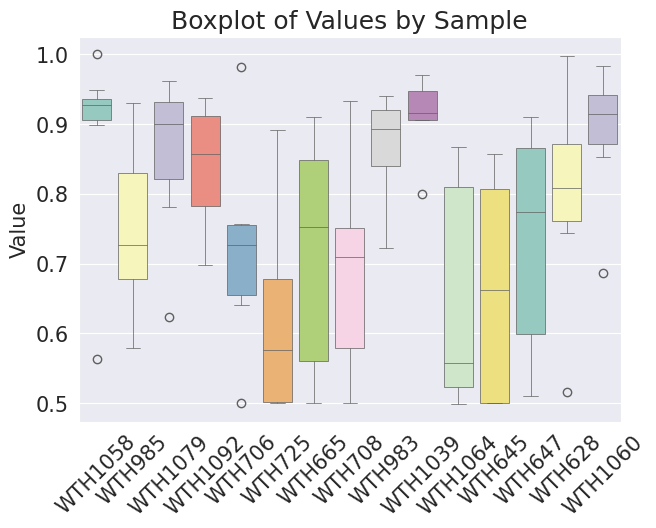

In [134]:
# plotting
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['font.size'] = 15
# plt.rcParams['font.sans-serif'] = 'Arial'

## sample 
ax = sns.boxplot(data=df_long, x='Sample', y='Value', linewidth=0.5, palette='Set3') # hue='CellType',

plt.xticks(rotation=45)
#plt.yticks(size=50)
ax.set_xlabel('')
ax.set_ylabel('Value')
ax.set_title('Boxplot of Values by Sample')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.savefig('./results/Sample_boxplot_{}.png'.format('MajorSample'), bbox_inches='tight')

/tmp/ipykernel_2526038/3346817691.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_long, x='CellType', y='Value', linewidth=0.5, palette='Set2') # hue='CellType',
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' no

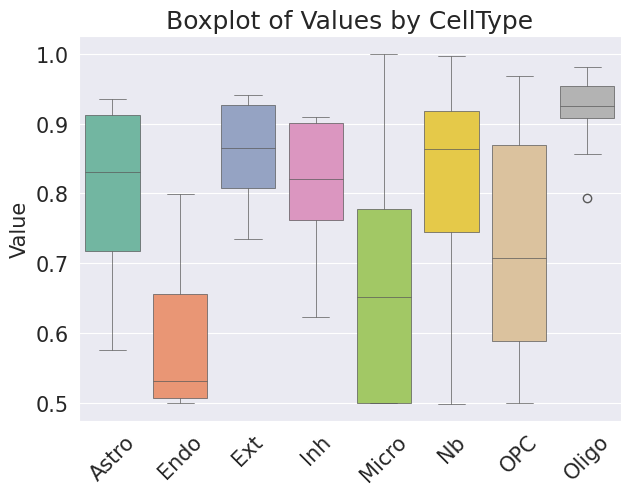

In [136]:
# plotting
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['font.size'] = 15

## Celltype 
ax = sns.boxplot(data=df_long, x='CellType', y='Value', linewidth=0.5, palette='Set2') # hue='CellType',

plt.xticks(rotation=45)
#plt.yticks(size=50)
ax.set_xlabel('')
ax.set_ylabel('Value')
ax.set_title('Boxplot of Values by CellType')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.savefig('./results/Sample_boxplot_{}.png'.format('MajorCellType'), bbox_inches='tight')

## 子类 celltype AUC 计算

In [137]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def calculate_auc_from_csv(adata_list):
    results = {}
    
    for adata_vis in adata_list:
        sample_name = adata_vis.obs['batch'].unique()[0]
        print('Calculating AUC for {}'.format(sample_name))
        
        # 创建 ground truth 和 predict 数据框
        df_ground_truth = pd.read_csv('./results/MinCellType/groundtruth/gold_{}.csv'.format(sample_name), index_col=0)
        df_predict = pd.read_csv('./results/predict_label/pred_Min_{}.csv'.format(sample_name), index_col=0)
        df_ground_truth = df_ground_truth[['predict_MinCelltype']]
        df_predict = df_predict[['predict_MinCelltype']]
        
        # 合并数据框以确保 ID 一致
        df = pd.merge(df_ground_truth, df_predict, left_index=True, right_index=True, suffixes=("_true", "_pred"))
        
        # 提取唯一的类别标签
        unique_classes = sorted(set(df["predict_MinCelltype_true"]).union(set(df["predict_MinCelltype_pred"])))
        
        # 二进制化类别标签
        y_true = label_binarize(df["predict_MinCelltype_true"], classes=unique_classes)
        y_pred = label_binarize(df["predict_MinCelltype_pred"], classes=unique_classes)
        
        # 计算每个类别的 AUC 值
        auc_scores = {}
        for i, class_name in enumerate(unique_classes):
            if len(np.unique(y_true[:, i])) > 1:  # 确保每个类别至少有一个正例和一个负例
                auc = roc_auc_score(y_true[:, i], y_pred[:, i])
                auc_scores[class_name] = auc
            else:
                print(f"Skipping AUC calculation for {class_name}: Not enough class instances.")
        
        # 存储结果
        results[sample_name] = auc_scores
            
    return results

In [138]:
## 亚类 celltype AUC 计算
Min_results = calculate_auc_from_csv(adata_list)

Calculating AUC for WTH1058
Skipping AUC calculation for Astro_AMY_CTX: Not enough class instances.
Skipping AUC calculation for Astro_CTX: Not enough class instances.
Skipping AUC calculation for Astro_HPC: Not enough class instances.
Skipping AUC calculation for Astro_HYPO: Not enough class instances.
Skipping AUC calculation for Astro_THAL_hab: Not enough class instances.
Skipping AUC calculation for Astro_THAL_lat: Not enough class instances.
Skipping AUC calculation for Astro_THAL_med: Not enough class instances.
Skipping AUC calculation for Ext_Amy_1: Not enough class instances.
Skipping AUC calculation for Ext_Amy_2: Not enough class instances.
Skipping AUC calculation for Ext_Hpc_CA1: Not enough class instances.
Skipping AUC calculation for Ext_Hpc_CA2: Not enough class instances.
Skipping AUC calculation for Ext_Hpc_CA3: Not enough class instances.
Skipping AUC calculation for Ext_Hpc_DG1: Not enough class instances.
Skipping AUC calculation for Ext_Hpc_DG2: Not enough class i

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(Min_results)
df['CellType'] = df.index
# 重塑数据为长格式
df_long = df.melt(id_vars=["CellType"], var_name="Sample", value_name="Value")

/tmp/ipykernel_2526038/317155572.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_long, x='Sample', y='Value', linewidth=0.5, palette='Set3') # hue='CellType',
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not f

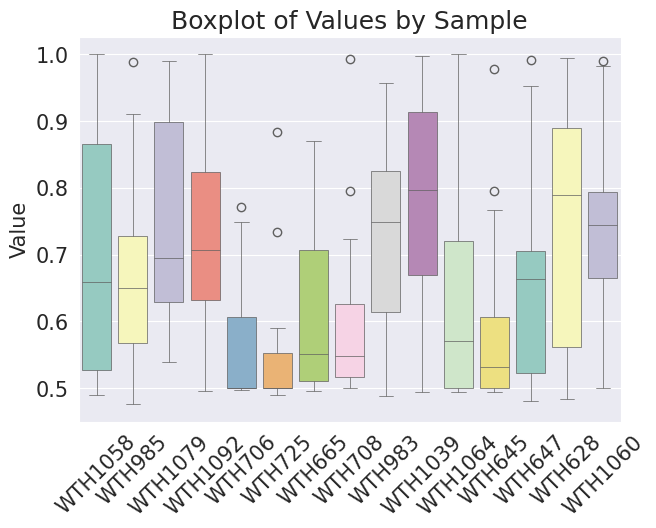

In [140]:
# plotting
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['font.size'] = 15
# plt.rcParams['font.sans-serif'] = 'Arial'

## sample 
ax = sns.boxplot(data=df_long, x='Sample', y='Value', linewidth=0.5, palette='Set3') # hue='CellType',

plt.xticks(rotation=45)
#plt.yticks(size=50)
ax.set_xlabel('')
ax.set_ylabel('Value')
ax.set_title('Boxplot of Values by Sample')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.savefig('./results/Sample_boxplot_{}.png'.format('MinSample'), bbox_inches='tight')

In [1]:
# plotting
plt.rcParams['figure.figsize'] = (24,6)
plt.rcParams['font.size'] = 15

## Celltype 
ax = sns.boxplot(data=df_long, x='CellType', y='Value', linewidth=0.5, palette='Set2') # hue='CellType',

plt.xticks(rotation=45)
#plt.yticks(size=50)
ax.set_xlabel('')
ax.set_ylabel('Value')
ax.set_title('Boxplot of Values by CellType')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.savefig('./results/Sample_boxplot_{}.png'.format('MinCellType'), bbox_inches='tight')

NameError: name 'plt' is not defined

In [3]:
sample_name = 'WTH1039'
meta = pd.read_csv('./results/predict_label/pred_Major_{}.csv'.format(sample_name), index_col=0)
meta

predict_MajorCelltype  Ext  Oligo  Inh  OPC  \
TTTACCACGAGATTCGTCTAAGTACGA                 Micro    0      0    0    0   
GTCGAATTACTAAACTGTAGTCATACG                    Nb    0      0    0    0   
AATGGAATACCCAGTGGAGCGACGGAT                   Ext    1      0    0    0   
GGCACGTTACTATGCAACCTAATAACG                 Astro    0      0    0    0   
TGTTTGTTACTAGATCAGCTCTGCTTC                   OPC    0      0    0    1   
...                                           ...  ...    ...  ...  ...   
CATGCGGTACATGGTACAAGGCACTAT                   Ext    1      0    0    0   
GGGTCTGCGATCGGTATTTCTGCGCTC                   Ext    1      0    0    0   
GAAATGATACCCTAACTGCTCTGCTTC                  Endo    0      0    0    0   
CATTGCCATGGTTCTATAAGGCACTAT                  Endo    0      0    0    0   
GGGCGTTGCTGGTGTGACCTAATAACG                  Endo    0      0    0    0   

                             Astro  Nb  Micro  Endo  
TTTACCACGAGATTCGTCTAAGTACGA      0   0      1     0  
GTCGAATTACTAAACTGTAGTCATACG      0   1      0     0  
AATGGAATACCCAGTGGAGCGACGGAT      0   0      0     0  
GGCACGTTACTATGCAACCTAATAACG      1   0      0     0  
TGTTTGTTACTAGATCAGCTCTGCTTC      0   0      0     0  
...                            ...  ..    ...   ...  
CATGCGGTACATGGTACAAGGCACTAT      0   0      0     0  
GGGTCTGCGATCGGTATTTCTGCGCTC      0   0      0     0  
GAAATGATACCCTAACTGCTCTGCTTC      0   0      0     1  
CATTGCCATGGTTCTATAAGGCACTAT      0   0      0     1  
GGGCGTTGCTGGTGTGACCTAATAACG      0   0      0     1  

[11479 rows x 9 columns]

In [13]:
results_folder = './results/MajorCellType'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)

# 读取每个文件并保存到DataFrame列表中
df_list = []
for adata_vis in adata_list:
    sample_name = adata_vis.obs['batch'].unique()[0]
    meta = pd.read_csv('./results/predict_label/pred_Major_{}.csv'.format(sample_name))
    meta.insert(loc=0, column='sample_id', value=sample_name)
    meta.rename(columns={'Unnamed: 0':'cell_name'}, inplace = True)
    meta.drop(columns='predict_MajorCelltype', inplace = True)
    df_list.append(meta)
    
## 合并DataFrame
df_merged = pd.concat(df_list, axis=0, ignore_index=False)
df_merged
## 保存结果
df_merged.to_csv("./results/predict_label/pred_Major_concat.csv", sep=',', index=False, header=True)

In [14]:
results_folder = './results/MinCellType'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)

# 读取每个文件并保存到DataFrame列表中
df_list = []
for adata_vis in adata_list:
    sample_name = adata_vis.obs['batch'].unique()[0]
    meta = pd.read_csv('./results/predict_label/pred_Min_{}.csv'.format(sample_name))
    meta.insert(loc=0, column='sample_id', value=sample_name)
    meta.rename(columns={'Unnamed: 0':'cell_name'}, inplace = True)
    meta.drop(columns='predict_MinCelltype', inplace = True)
    df_list.append(meta)
    
## 合并DataFrame
df_merged = pd.concat(df_list, axis=0, ignore_index=False)
df_merged
## 保存结果
df_merged.to_csv("./results/predict_label/pred_Min_concat.csv", sep=',', index=False, header=True)

In [11]:
df_merged

cell_name  Ext  Oligo  Inh  OPC  Astro  Nb  Micro  \
AGGGAGTCGAGGAGAAAGCACATACAA       Ext    1      0    0    0      0   0      0   
GTTTACTATGACGATCAGCACATACAA     Oligo    0      1    0    0      0   0      0   
ACCGTTCCGAGCCATTACGTGCCGATT     Oligo    0      1    0    0      0   0      0   
GGTTAACATGTTCTCAAGTGATAAGCA       Inh    0      0    1    0      0   0      0   
AAAGGGCTACAGAATAGGTGATAAGCA     Astro    0      0    0    0      1   0      0   
...                               ...  ...    ...  ...  ...    ...  ..    ...   
CTAACCCATGGCTGAACTTCAGGTGGC       Ext    1      0    0    0      0   0      0   
CCCTTAGGCTTTGATCGGCACATACAA      Endo    0      0    0    0      0   0      0   
CGATGCGCGAACAAGTATTCAGGTGGC      Endo    0      0    0    0      0   0      0   
TAGAGTCTACATGCAGCAGACCGCCTT      Endo    0      0    0    0      0   0      0   
AGTGATCGCTCTGTGATTTCAGGTGGC       Ext    1      0    0    0      0   0      0   

                             Endo  
AGGGAGTCGAGGAGAAAGCACATACAA     0  
GTTTACTATGACGATCAGCACATACAA     0  
ACCGTTCCGAGCCATTACGTGCCGATT     0  
GGTTAACATGTTCTCAAGTGATAAGCA     0  
AAAGGGCTACAGAATAGGTGATAAGCA     0  
...                           ...  
CTAACCCATGGCTGAACTTCAGGTGGC     0  
CCCTTAGGCTTTGATCGGCACATACAA     1  
CGATGCGCGAACAAGTATTCAGGTGGC     1  
TAGAGTCTACATGCAGCAGACCGCCTT     1  
AGTGATCGCTCTGTGATTTCAGGTGGC     0  

[102744 rows x 9 columns]

In [8]:
sample_name = 'WTH1039'
meta = pd.read_csv('./results/predict_label/pred_Major_{}.csv'.format(sample_name))
meta.insert(loc=0, column='sample_id', value=sample_name)
meta.rename(columns={'Unnamed: 0':'cell_name'}, inplace = True)
meta.drop(columns='predict_MajorCelltype', inplace = True)
meta

sample_id                    cell_name  Ext  Oligo  Inh  OPC  Astro  Nb  \
0       WTH1039  TTTACCACGAGATTCGTCTAAGTACGA    0      0    0    0      0   0   
1       WTH1039  GTCGAATTACTAAACTGTAGTCATACG    0      0    0    0      0   1   
2       WTH1039  AATGGAATACCCAGTGGAGCGACGGAT    1      0    0    0      0   0   
3       WTH1039  GGCACGTTACTATGCAACCTAATAACG    0      0    0    0      1   0   
4       WTH1039  TGTTTGTTACTAGATCAGCTCTGCTTC    0      0    0    1      0   0   
...         ...                          ...  ...    ...  ...  ...    ...  ..   
11474   WTH1039  CATGCGGTACATGGTACAAGGCACTAT    1      0    0    0      0   0   
11475   WTH1039  GGGTCTGCGATCGGTATTTCTGCGCTC    1      0    0    0      0   0   
11476   WTH1039  GAAATGATACCCTAACTGCTCTGCTTC    0      0    0    0      0   0   
11477   WTH1039  CATTGCCATGGTTCTATAAGGCACTAT    0      0    0    0      0   0   
11478   WTH1039  GGGCGTTGCTGGTGTGACCTAATAACG    0      0    0    0      0   0   

       Micro  Endo  
0          1     0  
1          0     0  
2          0     0  
3          0     0  
4          0     0  
...      ...   ...  
11474      0     0  
11475      0     0  
11476      0     1  
11477      0     1  
11478      0     1  

[11479 rows x 10 columns]

In [17]:
meta = pd.read_csv('./results/predict_label/pred_Min_{}.csv'.format('concat'))
meta

sample_id                    cell_name  Ext_L25  Ext_L56  Ext_Thal_1  \
0        WTH1058  AGGGAGTCGAGGAGAAAGCACATACAA        0        0           0   
1        WTH1058  GTTTACTATGACGATCAGCACATACAA        0        0           0   
2        WTH1058  ACCGTTCCGAGCCATTACGTGCCGATT        0        0           0   
3        WTH1058  GGTTAACATGTTCTCAAGTGATAAGCA        0        0           0   
4        WTH1058  AAAGGGCTACAGAATAGGTGATAAGCA        0        0           0   
...          ...                          ...      ...      ...         ...   
102739   WTH1060  CTAACCCATGGCTGAACTTCAGGTGGC        0        0           0   
102740   WTH1060  CCCTTAGGCTTTGATCGGCACATACAA        0        0           0   
102741   WTH1060  CGATGCGCGAACAAGTATTCAGGTGGC        0        0           0   
102742   WTH1060  TAGAGTCTACATGCAGCAGACCGCCTT        0        0           0   
102743   WTH1060  AGTGATCGCTCTGTGATTTCAGGTGGC        0        0           0   

        Ext_L5_1  Ext_Thal_2  Ext_L23  Oligo_2  Inh_1  ...  Astro_HPC  \
0              0           0        0        0      0  ...          0   
1              0           0        0        1      0  ...          0   
2              0           0        0        1      0  ...          0   
3              0           0        0        0      0  ...          0   
4              0           0        0        0      0  ...          0   
...          ...         ...      ...      ...    ...  ...        ...   
102739         1           0        0        0      0  ...          0   
102740         0           0        0        0      0  ...          0   
102741         0           0        0        0      0  ...          0   
102742         0           0        0        0      0  ...          0   
102743         0           0        1        0      0  ...          0   

        Ext_Hpc_CA2  Astro_WM  Inh_5  Astro_THAL_hab  Ext_Amy_1  Endo  \
0                 0         0      0               0          0     0   
1                 0         0      0               0          0     0   
2                 0         0      0               0          0     0   
3                 0         0      0               0          0     0   
4                 0         0      0               0          0     0   
...             ...       ...    ...             ...        ...   ...   
102739            0         0      0               0          0     0   
102740            0         0      0               0          0     1   
102741            0         0      0               0          0     1   
102742            0         0      0               0          0     1   
102743            0         0      0               0          0     0   

        Ext_Unk_3  Ext_Unk_2  Ext_Unk_1  
0               0          0          0  
1               0          0          0  
2               0          0          0  
3               0          0          0  
4               0          0          0  
...           ...        ...        ...  
102739          0          0          0  
102740          0          0          0  
102741          0          0          0  
102742          0          0          0  
102743          0          0          0  

[102744 rows x 57 columns]

In [18]:
meta['sample_id'].value_counts()

sample_id
WTH1064    14461
WTH1092    14386
WTH1060    11634
WTH983     11604
WTH1039    11479
WTH1058     9197
WTH985      7635
WTH1079     6146
WTH647      3731
WTH708      2837
WTH665      2812
WTH628      2231
WTH725      1638
WTH645      1554
WTH706      1399
Name: count, dtype: int64